In [2]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time

# Constants
MAX_PIPES = 40  # Updated to account for pipe1-pipe39 indexing
PIPE_OH_DIM = MAX_PIPES
PIPE_FEAT_DIM = 3  # length, radius, num_receivers
RECEIVER_FEAT_DIM = 10  # r, z, rad + 7 stats (from calculate_statistics function)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class EmitterDataset(Dataset):
    def __init__(self, data_dir):
        """
        Dataset for emitter localization using pipe network receiver data.
        
        Args:
            data_dir: Directory containing simulation runs (e.g., Outputs_Copy)
        """
        self.data_dir = data_dir
        # Get all run folders (timestamp directories)
        self.run_dirs = sorted([
            os.path.join(data_dir, d) for d in os.listdir(data_dir)
            if os.path.isdir(os.path.join(data_dir, d)) and not d.startswith('.')
        ])
        print(f"Found {len(self.run_dirs)} simulation runs in {data_dir}")
    
    def __len__(self):
        return len(self.run_dirs)
    
    def __getitem__(self, idx):
        """Process a single simulation run and return features and target"""
        run_dir = self.run_dirs[idx]
        
        # Initialize feature arrays
        pipe_features = np.zeros((MAX_PIPES, PIPE_FEAT_DIM), dtype=np.float32)
        receiver_features = []
        receiver_exists = np.zeros(MAX_PIPES, dtype=np.float32)
        
        # Process all pipe folders in this run
        for i in range(1, MAX_PIPES):  # Starting from pipe1
            pipe_dir = os.path.join(run_dir, f"pipe{i}")
            if not os.path.exists(pipe_dir):
                continue
                
            # Read pipe data from simulation_data.txt
            sim_data_path = os.path.join(pipe_dir, "simulation_data.txt")
            if os.path.exists(sim_data_path):
                with open(sim_data_path, 'r') as f:
                    line = f.readline().strip().split()
                    if len(line) >= 5:
                        pipe_id = int(line[0])  # Should be i
                        parent_id = int(line[1])  # -1 for root
                        length = float(line[2])
                        radius = float(line[3])
                        num_receivers = float(line[4])
                        
                        # Store pipe features (ignoring parent_id in features for simplicity)
                        pipe_features[pipe_id] = [length, radius, num_receivers]
            
            # Check for receiver files
            receiver_files = glob.glob(os.path.join(pipe_dir, "#*Ring type.txt"))
            for rec_file in receiver_files:
                try:
                    with open(rec_file, 'r') as f:
                        # First line contains pipe ID, r coordinate, z coordinate
                        header = f.readline().strip().split()
                        pipe_id = int(header[0])
                        r_coord = float(header[1])
                        z_coord = float(header[2])
                        
                        # Second line contains statistics
                        stats_line = f.readline().strip().split(',')
                        stats = [float(val.strip()) for val in stats_line]
                        
                        # Mark this pipe as having a receiver
                        receiver_exists[pipe_id] = 1.0
                        
                        # Add receiver features: [pipe_id, r, z, stats...]
                        receiver_features.append(np.array([pipe_id] + [r_coord, z_coord] + stats, dtype=np.float32))
                except Exception as e:
                    print(f"Error reading receiver file {rec_file}: {e}")
        
        # Read target from targetOutput.txt
        target_file = os.path.join(run_dir, "targetOutput.txt")
        if os.path.exists(target_file):
            with open(target_file, 'r') as f:
                target_data = f.readline().strip().split()
                emitter_pipe_id = int(target_data[0])
                emitter_r = float(target_data[1])
                emitter_z = float(target_data[2])
                target = np.array([emitter_pipe_id, emitter_r, emitter_z], dtype=np.float32)
        else:
            raise FileNotFoundError(f"Target file not found in {run_dir}")
        
        # Create feature vector
        # Flatten pipe features and append receiver information
        flat_pipe_features = pipe_features.flatten()
        
        # If no receivers, use empty array
        if not receiver_features:
            receiver_vec = np.zeros(3, dtype=np.float32)  # Just minimum placeholder
        else:
            # Take the mean of receiver features if there are multiple receivers
            receiver_vec = np.mean(receiver_features, axis=0) if len(receiver_features) > 1 else receiver_features[0]
        
        # Final feature vector: pipe features + receiver features + receiver existence flags
        features = np.concatenate([flat_pipe_features, receiver_vec, receiver_exists])
        
        return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [4]:
class EmitterLocalizationModel(nn.Module):
    def __init__(self, input_dim):
        super(EmitterLocalizationModel, self).__init__()
        
        # Calculate input dimensions based on our feature extraction
        self.network = nn.Sequential(
            # First layer
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Second layer
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Third layer
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            # Output layer - predict pipe_id, r, z
            nn.Linear(128, 3)
        )
        
    def forward(self, x):
        return self.network(x)

In [5]:
def train_model(train_loader, val_loader, model, epochs=50, lr=3e-4):
    """Train the emitter localization model"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0.0
        start_time = time.time()
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch:02d}", unit="batch")
        
        for features, targets in loop:
            features, targets = features.to(DEVICE), targets.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            batch_loss = loss.item()
            train_loss += batch_loss * features.size(0)
            
            loop.set_postfix(train_loss=f"{batch_loss:.4f}")
            
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        elapsed = time.time() - start_time
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(DEVICE), targets.to(DEVICE)
                outputs = model(features)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * features.size(0)
                
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Time: {elapsed:.2f}s")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_emitter_model.pt")
            print(f"New best model saved with validation loss: {best_val_loss:.6f}")
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('emitter_training_loss.png')
    plt.show()
    
    return train_losses, val_losses

def evaluate_model(model, test_loader):
    """Evaluate the trained model"""
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0.0
    
    # For pipe prediction accuracy
    correct_pipe = 0
    total = 0
    
    # For position error metrics
    position_errors = []
    
    with torch.no_grad():
        for features, targets in tqdm(test_loader, desc="Evaluating"):
            features, targets = features.to(DEVICE), targets.to(DEVICE)
            outputs = model(features)
            
            # Calculate loss
            loss = criterion(outputs, targets)
            test_loss += loss.item() * features.size(0)
            
            # Check pipe prediction accuracy
            pred_pipe = torch.round(outputs[:, 0])
            true_pipe = targets[:, 0]
            correct_pipe += (pred_pipe == true_pipe).sum().item()
            total += targets.size(0)
            
            # Calculate position error (Euclidean distance) for r and z coordinates
            pred_r_z = outputs[:, 1:]
            true_r_z = targets[:, 1:]
            position_error = torch.sqrt(torch.sum((pred_r_z - true_r_z) ** 2, dim=1))
            position_errors.extend(position_error.cpu().numpy())
    
    avg_test_loss = test_loss / len(test_loader.dataset)
    pipe_accuracy = correct_pipe / total * 100
    avg_position_error = np.mean(position_errors)
    
    print(f"Test Loss: {avg_test_loss:.6f}")
    print(f"Pipe Prediction Accuracy: {pipe_accuracy:.2f}%")
    print(f"Average Position Error: {avg_position_error:.6f} units")
    
    return avg_test_loss, pipe_accuracy, avg_position_error

Found 1000 simulation runs in /Users/daghanerdonmez/Desktop/molecular-simulation-mlp/output-processing/Outputs_Copy
Dataset split: Train=700, Validation=150, Test=150
Input dimension: 170
Training on cpu
EmitterLocalizationModel(
  (network): Sequential(
    (0): Linear(in_features=170, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=3, bias=True)
  )
)


Epoch 01: 100%|██████████| 44/44 [00:05<00:00,  7.50batch/s, train_loss=147.0908]


Epoch 01 | Train Loss: 166.154053 | Val Loss: 160.652044 | Time: 5.90s
New best model saved with validation loss: 160.652044


Epoch 02: 100%|██████████| 44/44 [00:05<00:00,  8.37batch/s, train_loss=96.4437] 


Epoch 02 | Train Loss: 154.134660 | Val Loss: 149.289876 | Time: 5.26s
New best model saved with validation loss: 149.289876


Epoch 03: 100%|██████████| 44/44 [00:04<00:00,  9.29batch/s, train_loss=221.7527]


Epoch 03 | Train Loss: 145.277720 | Val Loss: 141.582995 | Time: 4.74s
New best model saved with validation loss: 141.582995


Epoch 04: 100%|██████████| 44/44 [00:04<00:00, 10.06batch/s, train_loss=74.3479] 


Epoch 04 | Train Loss: 134.954573 | Val Loss: 130.309761 | Time: 4.37s
New best model saved with validation loss: 130.309761


Epoch 05: 100%|██████████| 44/44 [00:03<00:00, 11.56batch/s, train_loss=103.3242]


Epoch 05 | Train Loss: 125.343776 | Val Loss: 121.164361 | Time: 3.81s
New best model saved with validation loss: 121.164361


Epoch 06: 100%|██████████| 44/44 [00:03<00:00, 14.14batch/s, train_loss=101.1556]


Epoch 06 | Train Loss: 115.533221 | Val Loss: 109.588768 | Time: 3.11s
New best model saved with validation loss: 109.588768


Epoch 07: 100%|██████████| 44/44 [00:02<00:00, 15.05batch/s, train_loss=97.0200] 


Epoch 07 | Train Loss: 105.909125 | Val Loss: 107.581593 | Time: 2.93s
New best model saved with validation loss: 107.581593


Epoch 08: 100%|██████████| 44/44 [00:02<00:00, 15.53batch/s, train_loss=87.2675] 


Epoch 08 | Train Loss: 95.785332 | Val Loss: 89.253256 | Time: 2.83s
New best model saved with validation loss: 89.253256


Epoch 09: 100%|██████████| 44/44 [00:02<00:00, 15.30batch/s, train_loss=77.0303] 


Epoch 09 | Train Loss: 86.837989 | Val Loss: 87.772086 | Time: 2.88s
New best model saved with validation loss: 87.772086


Epoch 10: 100%|██████████| 44/44 [00:02<00:00, 16.93batch/s, train_loss=44.7157] 


Epoch 10 | Train Loss: 77.473972 | Val Loss: 81.634914 | Time: 2.60s
New best model saved with validation loss: 81.634914


Epoch 11: 100%|██████████| 44/44 [00:02<00:00, 16.64batch/s, train_loss=39.1115] 


Epoch 11 | Train Loss: 69.392478 | Val Loss: 75.209595 | Time: 2.65s
New best model saved with validation loss: 75.209595


Epoch 12: 100%|██████████| 44/44 [00:02<00:00, 16.59batch/s, train_loss=24.3635] 


Epoch 12 | Train Loss: 61.754271 | Val Loss: 62.425516 | Time: 2.65s
New best model saved with validation loss: 62.425516


Epoch 13: 100%|██████████| 44/44 [00:02<00:00, 17.93batch/s, train_loss=57.1068] 


Epoch 13 | Train Loss: 54.498761 | Val Loss: 54.233137 | Time: 2.45s
New best model saved with validation loss: 54.233137


Epoch 14: 100%|██████████| 44/44 [00:02<00:00, 16.67batch/s, train_loss=49.8874] 


Epoch 14 | Train Loss: 49.171703 | Val Loss: 52.188121 | Time: 2.64s
New best model saved with validation loss: 52.188121


Epoch 15: 100%|██████████| 44/44 [00:02<00:00, 16.39batch/s, train_loss=28.6182]


Epoch 15 | Train Loss: 43.327970 | Val Loss: 44.412485 | Time: 2.69s
New best model saved with validation loss: 44.412485


Epoch 16: 100%|██████████| 44/44 [00:02<00:00, 16.69batch/s, train_loss=22.9347]


Epoch 16 | Train Loss: 40.470458 | Val Loss: 41.439471 | Time: 2.64s
New best model saved with validation loss: 41.439471


Epoch 17: 100%|██████████| 44/44 [00:02<00:00, 17.98batch/s, train_loss=34.5377]


Epoch 17 | Train Loss: 36.646908 | Val Loss: 38.748227 | Time: 2.45s
New best model saved with validation loss: 38.748227


Epoch 18: 100%|██████████| 44/44 [00:02<00:00, 17.61batch/s, train_loss=35.3465]


Epoch 18 | Train Loss: 35.276923 | Val Loss: 40.149268 | Time: 2.50s


Epoch 19: 100%|██████████| 44/44 [00:02<00:00, 17.97batch/s, train_loss=39.7866]


Epoch 19 | Train Loss: 33.491610 | Val Loss: 38.033619 | Time: 2.45s
New best model saved with validation loss: 38.033619


Epoch 20: 100%|██████████| 44/44 [00:02<00:00, 16.57batch/s, train_loss=46.2407]


Epoch 20 | Train Loss: 32.880310 | Val Loss: 35.422155 | Time: 2.66s
New best model saved with validation loss: 35.422155


Epoch 21: 100%|██████████| 44/44 [00:02<00:00, 17.81batch/s, train_loss=25.9686]


Epoch 21 | Train Loss: 29.130906 | Val Loss: 36.223006 | Time: 2.47s


Epoch 22: 100%|██████████| 44/44 [00:02<00:00, 17.22batch/s, train_loss=29.2031]


Epoch 22 | Train Loss: 30.006824 | Val Loss: 33.004101 | Time: 2.56s
New best model saved with validation loss: 33.004101


Epoch 23: 100%|██████████| 44/44 [00:02<00:00, 18.14batch/s, train_loss=33.8353]


Epoch 23 | Train Loss: 28.975128 | Val Loss: 33.658723 | Time: 2.43s


Epoch 24: 100%|██████████| 44/44 [00:02<00:00, 16.61batch/s, train_loss=33.1560]


Epoch 24 | Train Loss: 28.694130 | Val Loss: 32.234673 | Time: 2.65s
New best model saved with validation loss: 32.234673


Epoch 25: 100%|██████████| 44/44 [00:02<00:00, 17.09batch/s, train_loss=41.4737]


Epoch 25 | Train Loss: 27.188960 | Val Loss: 33.918145 | Time: 2.58s


Epoch 26: 100%|██████████| 44/44 [00:02<00:00, 17.77batch/s, train_loss=30.5452]


Epoch 26 | Train Loss: 28.173331 | Val Loss: 31.649911 | Time: 2.48s
New best model saved with validation loss: 31.649911


Epoch 27: 100%|██████████| 44/44 [00:02<00:00, 16.33batch/s, train_loss=26.7387]


Epoch 27 | Train Loss: 28.208512 | Val Loss: 30.595216 | Time: 2.70s
New best model saved with validation loss: 30.595216


Epoch 28: 100%|██████████| 44/44 [00:02<00:00, 18.19batch/s, train_loss=11.4948]


Epoch 28 | Train Loss: 26.868157 | Val Loss: 29.606199 | Time: 2.42s
New best model saved with validation loss: 29.606199


Epoch 29: 100%|██████████| 44/44 [00:02<00:00, 17.58batch/s, train_loss=22.5147]


Epoch 29 | Train Loss: 26.367716 | Val Loss: 30.560763 | Time: 2.50s


Epoch 30: 100%|██████████| 44/44 [00:02<00:00, 17.10batch/s, train_loss=54.3361]


Epoch 30 | Train Loss: 27.324154 | Val Loss: 28.600942 | Time: 2.57s
New best model saved with validation loss: 28.600942


Epoch 31: 100%|██████████| 44/44 [00:02<00:00, 15.64batch/s, train_loss=28.0806]


Epoch 31 | Train Loss: 26.618676 | Val Loss: 29.378039 | Time: 2.81s


Epoch 32: 100%|██████████| 44/44 [00:02<00:00, 16.18batch/s, train_loss=23.8488]


Epoch 32 | Train Loss: 26.883594 | Val Loss: 28.208278 | Time: 2.72s
New best model saved with validation loss: 28.208278


Epoch 33: 100%|██████████| 44/44 [00:02<00:00, 16.75batch/s, train_loss=41.9275]


Epoch 33 | Train Loss: 27.924671 | Val Loss: 32.379151 | Time: 2.63s


Epoch 34: 100%|██████████| 44/44 [00:02<00:00, 17.93batch/s, train_loss=25.4197]


Epoch 34 | Train Loss: 26.944664 | Val Loss: 27.827954 | Time: 2.45s
New best model saved with validation loss: 27.827954


Epoch 35: 100%|██████████| 44/44 [00:02<00:00, 17.00batch/s, train_loss=14.8168]


Epoch 35 | Train Loss: 27.214497 | Val Loss: 31.781186 | Time: 2.59s


Epoch 36: 100%|██████████| 44/44 [00:02<00:00, 17.95batch/s, train_loss=31.6558]


Epoch 36 | Train Loss: 26.935001 | Val Loss: 29.190780 | Time: 2.45s


Epoch 37: 100%|██████████| 44/44 [00:02<00:00, 17.44batch/s, train_loss=16.0677]


Epoch 37 | Train Loss: 27.070803 | Val Loss: 29.342216 | Time: 2.52s


Epoch 38: 100%|██████████| 44/44 [00:02<00:00, 18.08batch/s, train_loss=27.8466]


Epoch 38 | Train Loss: 27.402120 | Val Loss: 31.401558 | Time: 2.43s


Epoch 39: 100%|██████████| 44/44 [00:02<00:00, 18.12batch/s, train_loss=16.1522]


Epoch 39 | Train Loss: 27.196494 | Val Loss: 28.770313 | Time: 2.43s


Epoch 40: 100%|██████████| 44/44 [00:02<00:00, 18.10batch/s, train_loss=12.6821]


Epoch 40 | Train Loss: 25.634066 | Val Loss: 30.829403 | Time: 2.43s


Epoch 41: 100%|██████████| 44/44 [00:02<00:00, 17.35batch/s, train_loss=25.1323]


Epoch 41 | Train Loss: 25.332212 | Val Loss: 30.988080 | Time: 2.54s


Epoch 42: 100%|██████████| 44/44 [00:02<00:00, 18.08batch/s, train_loss=20.9342]


Epoch 42 | Train Loss: 26.271837 | Val Loss: 29.198006 | Time: 2.43s


Epoch 43: 100%|██████████| 44/44 [00:02<00:00, 18.10batch/s, train_loss=37.4580]


Epoch 43 | Train Loss: 25.381503 | Val Loss: 28.907397 | Time: 2.43s


Epoch 44: 100%|██████████| 44/44 [00:02<00:00, 17.42batch/s, train_loss=9.7871] 


Epoch 44 | Train Loss: 25.721187 | Val Loss: 28.596002 | Time: 2.53s


Epoch 45: 100%|██████████| 44/44 [00:02<00:00, 18.13batch/s, train_loss=28.1364]


Epoch 45 | Train Loss: 25.061563 | Val Loss: 27.469413 | Time: 2.43s
New best model saved with validation loss: 27.469413


Epoch 46: 100%|██████████| 44/44 [00:02<00:00, 16.85batch/s, train_loss=31.9821]


Epoch 46 | Train Loss: 24.678441 | Val Loss: 27.426629 | Time: 2.61s
New best model saved with validation loss: 27.426629


Epoch 47: 100%|██████████| 44/44 [00:02<00:00, 17.99batch/s, train_loss=13.2756]


Epoch 47 | Train Loss: 26.356708 | Val Loss: 30.924584 | Time: 2.45s


Epoch 48: 100%|██████████| 44/44 [00:02<00:00, 17.29batch/s, train_loss=26.2280]


Epoch 48 | Train Loss: 24.572751 | Val Loss: 27.793844 | Time: 2.55s


Epoch 49: 100%|██████████| 44/44 [00:02<00:00, 15.02batch/s, train_loss=23.9578]


Epoch 49 | Train Loss: 24.832055 | Val Loss: 28.579456 | Time: 2.93s


Epoch 50: 100%|██████████| 44/44 [00:02<00:00, 17.96batch/s, train_loss=22.9848]


Epoch 50 | Train Loss: 25.312089 | Val Loss: 30.071611 | Time: 2.45s


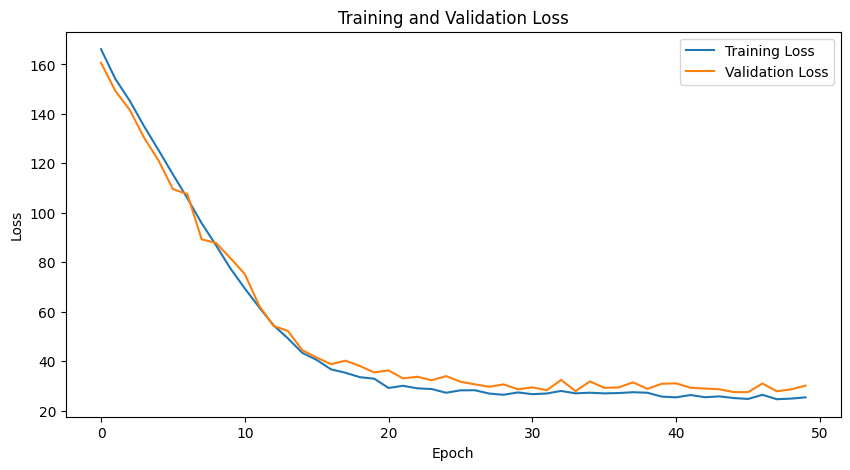

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 11.49it/s]

Test Loss: 22.970728
Pipe Prediction Accuracy: 6.67%
Average Position Error: 0.023907 units
Training and evaluation complete.


In [6]:
def main():
    """Main execution function"""
    # Paths
    data_dir = "/Users/daghanerdonmez/Desktop/molecular-simulation-mlp/output-processing/Outputs_Copy"
    
    # Create dataset
    all_data = EmitterDataset(data_dir)
    
    # Split dataset: 70% training, 15% validation, 15% testing
    total_size = len(all_data)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        all_data, [train_size, val_size, test_size]
    )
    
    print(f"Dataset split: Train={len(train_dataset)}, Validation={len(val_dataset)}, Test={len(test_dataset)}")
    
    # Create data loaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Get sample data to determine input dimension
    sample_features, _ = next(iter(train_loader))
    input_dim = sample_features.shape[1]
    print(f"Input dimension: {input_dim}")
    
    # Initialize model
    model = EmitterLocalizationModel(input_dim).to(DEVICE)
    print(f"Training on {DEVICE}")
    print(model)
    
    # Train model
    train_losses, val_losses = train_model(train_loader, val_loader, model, epochs=50)
    
    # Load best model for evaluation
    model.load_state_dict(torch.load("best_emitter_model.pt"))
    
    # Evaluate on test set
    test_loss, pipe_accuracy, position_error = evaluate_model(model, test_loader)
    
    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'test_loss': test_loss,
        'pipe_accuracy': pipe_accuracy,
        'position_error': position_error
    }, "emitter_model_final.pt")
    
    print("Training and evaluation complete.")

if __name__ == "__main__":
    main()